In [1]:
import sys
sys.path.insert(1, '../src/')
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets,transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.nn.utils import vector_to_parameters, parameters_to_vector
import matplotlib.pyplot as plt
import time
import os
import copy
import utils
from torchsummary import summary
import models
import random
import torch.nn.functional as F
import shutil
from torchsummary import summary
import torch
import torch.nn.functional as F
from utils import H5Dataset
from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
import cv2

In [2]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [39]:
class args:
    model_file='niid_nodefense_model.pt'
    data='fedemnist'
    bs = 64
    device = 'cuda:0'
    lr = 0
    moment = 0.9
    wd = 0
    epochs=50
    nesterov = True
    base_class = 1
    target_class = 4
    poison_frac = 0.05
    pattern_type='apple'

In [40]:
train_dataset, val_dataset = utils.get_datasets(args.data)
idxs = (val_dataset.targets == args.base_class).nonzero().flatten().tolist()
poisoned_val_set = utils.DatasetSplit(copy.deepcopy(val_dataset), idxs)
utils.poison_dataset(poisoned_val_set.dataset, args, poison_all=True)

In [41]:
val_loader =  DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, num_workers=2, pin_memory=True)
poisoned_val_loader = DataLoader(poisoned_val_set, batch_size=args.bs, shuffle=False, num_workers=0, pin_memory=True) 

In [42]:
model = torch.load(args.model_file)
model.eval()
criterion = nn.CrossEntropyLoss().to(args.device)

In [43]:
_, (imgs, labels) = next(enumerate(poisoned_val_loader))
idx = (labels==args.target_class).nonzero()[36].item()

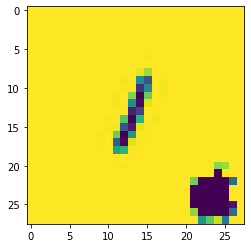

In [44]:
img = imgs[idx]
plt.imshow(img.squeeze(0).cpu().numpy())

In [ ]:
img = img.view(1, 1, 28, 28).to(args.device)

In [ ]:
output = model(img)

In [ ]:
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = pred_label_idx.item()
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

In [ ]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(img, target=pred_label_idx, n_steps=1000)

In [ ]:
default_cmap = cm.get_cmap('inferno')
gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([img * 0, img * 1])

attributions_gs = gradient_shap.attribute(img,
                                          n_samples=100,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(attributions_gs.squeeze().cpu().detach().numpy().reshape(28, 28, 1),
                                      img.squeeze().cpu().detach().numpy(),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
default_cmap = cm.get_cmap('Greens')

_ = viz.visualize_image_attr_multiple(attributions_ig.squeeze().cpu().detach().numpy().reshape(28, 28, 1),
                            img.squeeze().cpu().detach().numpy(), 
                             ["original_image", "heat_map"],
                            ["all", "positive"],
                            cmap=default_cmap,
                            show_colorbar=True)